In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV  #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

data = pd.read_csv('./data/aggregate_201019.csv')
target = 'reuse_7'
IDcol = 'project'
data.dropna(inplace=True)
data.pop('maven_release')
data.pop('release')

0        1.0.0
1          0.7
2       2.5.23
3       2.3.14
4       2.5.23
        ...   
425      2.4.8
426      2.6.1
427    1.3.7-3
428    1.4.3-1
429        1.1
Name: release, Length: 270, dtype: object

In [2]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    #print(alg)
    #print(alg.booster())
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    predictors = feat_imp.index.tolist()
    plt.ylabel('Feature Importance Score')
    feat_imp2 = feat_imp.to_frame()
    for predictor in predictors:
        if feat_imp2[0][predictor] <10:
            print("Removed")
            print(predictor)
            predictors.remove(predictor)
    return predictors

In [3]:
def modelfit1(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mlogloss', early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='mlogloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    #print(alg)
    #print(alg.booster())
    #feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #predictors = feat_imp.index.tolist()
    #plt.ylabel('Feature Importance Score')
    #feat_imp2 = feat_imp.to_frame()
    #for predictor in predictors:
    #    if feat_imp2[0][predictor] <10:
    #        print("Removed")
    #        print(predictor)
    #        predictors.remove(predictor)
    #return predictors
    return alg

In [4]:
def f(x):
    arr = [29, 50.6, 160, 600.2,964.12, 3066.38]
    for i in range(len(arr)+1):
        if i == len(arr):
            return int(i)
        if x['maven_reuse']<arr[i]:
            return int(i) 
data['reuse_7'] = data.apply(f, axis=1)

In [5]:
data.pop('maven_reuse')

0       23.0
1       49.0
2      208.0
3       31.0
4      135.0
       ...  
425     99.0
426     10.0
427     19.0
428     18.0
429     44.0
Name: maven_reuse, Length: 270, dtype: float64

In [6]:
predictors = [x for x in data.columns if x not in [target, IDcol]]

In [7]:
for i in data.reuse_7:
    if i == 6:
        print(True)

True
True
True
True
True
True
True
True
True


In [8]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2)
y_test = test['reuse_7']

[08:54:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:54:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:54:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

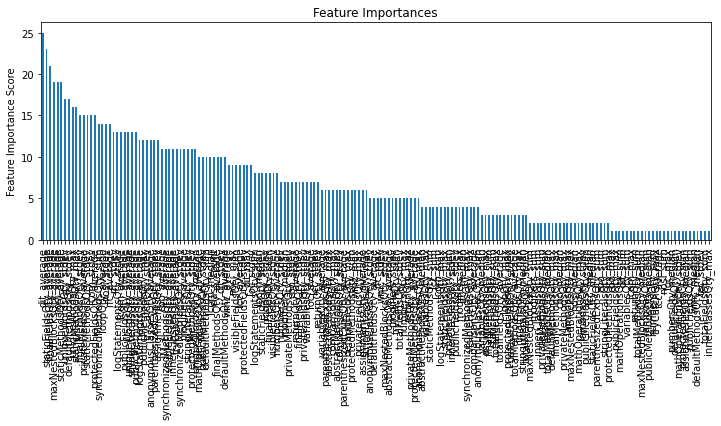

In [9]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 num_class = 7,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
predictors = modelfit(xgb1, train, predictors)

In [10]:
param_test1 = {
 'max_depth':range(3,10,1),
 'min_child_weight':range(1,6,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=21, max_depth=5,
 min_child_weight=1, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob',num_class=7, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_

[08:54:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 3, 'min_child_weight': 1}, -1.6231537708079333)

In [11]:
param_test2 = {
 'max_depth': [2, 3, 4, 5],
 'min_child_weight': [1, 2, 3, 4,5, 6, 7, 8, 9]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=21, max_depth=5,
 min_child_weight=2, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=7), 
 param_grid = param_test2, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

[08:54:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 3, 'min_child_weight': 1}, -1.6231537708079333)

In [12]:
param_test2b = {
 'min_child_weight':[1, 2,4,6,8,10,12,14,16, 21, 22, 23, 24, 25]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=21, max_depth=2,
 min_child_weight=2, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=7), 
 param_grid = param_test2b, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

[08:54:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=2, min_child_weight=2,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=21, n_jobs=None, nthread=4,
                                     num_class=7, num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

In [13]:
gsearch2b.best_params_, gsearch2b.best_score_

({'min_child_weight': 1}, -1.6337228010465679)

In [23]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=21, max_depth=3,
 min_child_weight=1, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=7), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

[08:55:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=3, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=21, n_jobs=None, nthread=4,
                                     num_class=7, num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weig

In [24]:
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.3}, -1.6149320910836376)

[08:55:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:55:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:55:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

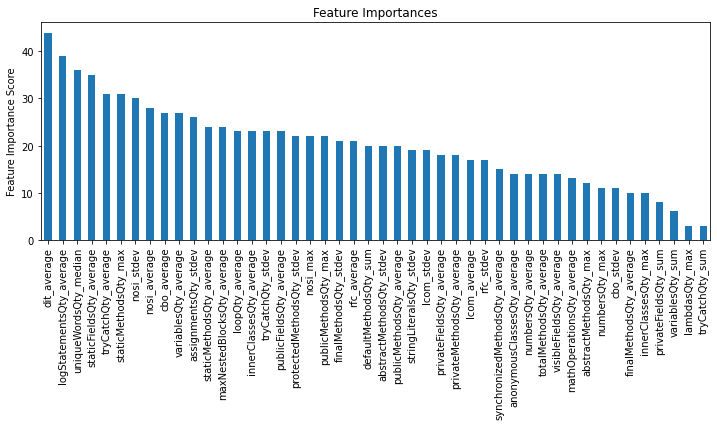

In [25]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 scale_pos_weight=1,
 num_class=7,
 seed=27)
predictors = modelfit(xgb2, train, predictors)

In [26]:
print(len(predictors))

44


In [27]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=26, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=7), 
 param_grid = param_test4, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.best_params_, gsearch4.best_score_

[08:56:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.9, 'subsample': 0.9}, -1.5849860257455333)

In [28]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(55,75,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=26, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.9, colsample_bytree=0.9,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=7), 
 param_grid = param_test5, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.best_score_, gsearch5.best_params_

[08:56:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


(-1.5833141976412204, {'colsample_bytree': 0.55, 'subsample': 0.85})

In [29]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=26, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.85, colsample_bytree=0.55,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=7), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
gsearch6.best_params_, gsearch6.best_score_

[08:56:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0.1}, -1.5825137854331266)

In [30]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=26, max_depth=3,
 min_child_weight=1, gamma=0.3, subsample=0.85, colsample_bytree=0.55,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27, num_class=7), 
 param_grid = param_test7, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
gsearch7.best_params_, gsearch7.best_score_

[08:56:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0}, -1.5833141976412204)

[08:55:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:55:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:55:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

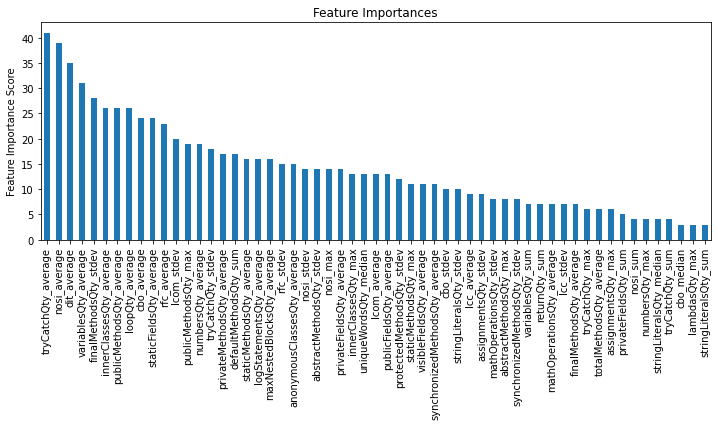

In [22]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=1,
 gamma=0.3,
 subsample=0.85,
 colsample_bytree=0.55,
 reg_alpha=0.0,
 objective= 'multi:softprob',
 num_class=7,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
predictors = modelfit(xgb3, train, predictors)

In [31]:
len(predictors)

44

In [32]:
predictors.sort()

In [33]:
xgb4 = modelfit1(xgb3, train, predictors)

[08:59:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:59:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:59:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters a

N estimators = 22, depth =3, child weight = 5, gamma 0.1, subsample=0.85, colsample=0.7

In [34]:
xgb4.get_booster().feature_names

['abstractMethodsQty_max',
 'abstractMethodsQty_stdev',
 'anonymousClassesQty_average',
 'assignmentsQty_stdev',
 'cbo_average',
 'cbo_stdev',
 'defaultMethodsQty_sum',
 'dit_average',
 'finalMethodsQty_average',
 'finalMethodsQty_stdev',
 'innerClassesQty_average',
 'innerClassesQty_max',
 'lcom_average',
 'lcom_stdev',
 'logStatementsQty_average',
 'loopQty_average',
 'mathOperationsQty_average',
 'maxNestedBlocksQty_average',
 'nosi_average',
 'nosi_max',
 'nosi_stdev',
 'numbersQty_average',
 'numbersQty_max',
 'privateFieldsQty_average',
 'privateMethodsQty_average',
 'protectedMethodsQty_stdev',
 'publicFieldsQty_average',
 'publicMethodsQty_average',
 'publicMethodsQty_max',
 'rfc_average',
 'rfc_stdev',
 'staticFieldsQty_average',
 'staticMethodsQty_average',
 'staticMethodsQty_max',
 'stringLiteralsQty_stdev',
 'synchronizedMethodsQty_average',
 'totalMethodsQty_average',
 'tryCatchQty_average',
 'tryCatchQty_stdev',
 'tryCatchQty_sum',
 'uniqueWordsQty_median',
 'variablesQty

In [35]:
print(xgb3)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=34, n_jobs=4, nthread=4, num_class=7,
              num_parallel_tree=1, objective='multi:softprob', random_state=27,
              reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=27,
              subsample=0.85, tree_method='exact', validate_parameters=1,
              verbosity=None)


In [36]:
train.head()

,project,class_count,synchronizedMethodsQty_sum,synchronizedMethodsQty_average,synchronizedMethodsQty_stdev,synchronizedMethodsQty_median,synchronizedMethodsQty_min,synchronizedMethodsQty_max,parenthesizedExpsQty_sum,parenthesizedExpsQty_average,...,innerClassesQty_median,innerClassesQty_min,innerClassesQty_max,comparisonsQty_sum,comparisonsQty_average,comparisonsQty_stdev,comparisonsQty_median,comparisonsQty_min,comparisonsQty_max,reuse_7
75,ehcache,2355,152.0,0.064736,0.588253,0.0,0.0,18.0,1327.0,0.565162,...,0.0,0.0,53.0,2754.0,1.172913,8.407490,0.0,0.0,354.0,2
152,jdom2,570,390.0,0.684211,2.884160,0.0,0.0,30.0,554.0,0.971930,...,0.0,0.0,6.0,2554.0,4.480702,15.513716,0.0,0.0,191.0,3
295,scala-compiler,512,136.0,0.322275,1.818466,0.0,0.0,21.0,932.0,2.208531,...,0.0,0.0,7.0,847.0,2.007109,12.927992,0.0,0.0,224.0,3
406,util-logging,112,0.0,0.000000,0.000000,0.0,0.0,0.0,7.0,0.062500,...,0.0,0.0,2.0,27.0,0.241071,1.555262,0.0,0.0,16.0,1
37,caffeine,908,50.0,0.055066,0.442064,0.0,0.0,7.0,1070.0,1.178414,...,0.0,0.0,33.0,1314.0,1.447137,6.546119,0.0,0.0,137.0,4


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 75 to 242
Columns: 267 entries, project to reuse_7
dtypes: float64(264), int64(2), object(1)
memory usage: 452.2+ KB


In [38]:
train.describe()

,class_count,synchronizedMethodsQty_sum,synchronizedMethodsQty_average,synchronizedMethodsQty_stdev,synchronizedMethodsQty_median,synchronizedMethodsQty_min,synchronizedMethodsQty_max,parenthesizedExpsQty_sum,parenthesizedExpsQty_average,parenthesizedExpsQty_stdev,...,innerClassesQty_median,innerClassesQty_min,innerClassesQty_max,comparisonsQty_sum,comparisonsQty_average,comparisonsQty_stdev,comparisonsQty_median,comparisonsQty_min,comparisonsQty_max,reuse_7
count,216.000000,216.000000,216.000000,216.000000,216.0,216.0,216.000000,216.000000,216.000000,216.000000,...,216.0,216.0,216.000000,216.000000,216.000000,216.000000,216.000000,216.0,216.000000,216.000000
mean,2023.643519,149.263889,0.099031,0.675764,0.0,0.0,12.495370,1201.777778,0.873012,3.860858,...,0.0,0.0,26.976852,2721.981481,1.868553,6.199023,0.134259,0.0,94.689815,2.050926
std,3916.908942,298.147006,0.169595,1.027705,0.0,0.0,17.704289,2530.284967,1.085948,4.953184,...,0.0,0.0,43.500061,7317.227574,2.807757,6.459296,0.801471,0.0,100.945581,1.531741
min,2.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,91.000000,1.000000,0.001953,0.043606,0.0,0.0,1.000000,40.750000,0.211579,0.976901,...,0.0,0.0,3.000000,96.750000,0.722066,2.413666,0.000000,0.0,20.000000,1.000000
50%,375.000000,16.000000,0.040968,0.376822,0.0,0.0,5.000000,184.000000,0.479183,2.177958,...,0.0,0.0,8.500000,523.500000,1.161180,4.841433,0.000000,0.0,48.000000,2.000000
75%,1278.250000,96.250000,0.095154,0.818721,0.0,0.0,21.000000,793.250000,1.100879,4.441952,...,0.0,0.0,25.000000,1677.750000,2.346202,7.739508,0.000000,0.0,143.000000,3.000000
max,14013.000000,1248.000000,1.169014,7.517913,0.0,0.0,104.000000,20263.000000,6.380282,24.466385,...,0.0,0.0,332.000000,88339.000000,36.071429,58.773966,8.500000,0.0,599.000000,6.000000


In [39]:
for i in train.columns:
    if i not in predictors:
        train.pop(i)

In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 75 to 242
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   synchronizedMethodsQty_average  216 non-null    float64
 1   lcom_average                    216 non-null    float64
 2   lcom_stdev                      216 non-null    float64
 3   publicMethodsQty_average        216 non-null    float64
 4   publicMethodsQty_max            216 non-null    float64
 5   staticFieldsQty_average         216 non-null    float64
 6   publicFieldsQty_average         216 non-null    float64
 7   logStatementsQty_average        216 non-null    float64
 8   tryCatchQty_sum                 216 non-null    float64
 9   tryCatchQty_average             216 non-null    float64
 10  tryCatchQty_stdev               216 non-null    float64
 11  maxNestedBlocksQty_average      216 non-null    float64
 12  rfc_average                     216

In [41]:
train3 = train.reindex(sorted(train.columns), axis=1)

In [42]:
train3.head()

,abstractMethodsQty_max,abstractMethodsQty_stdev,anonymousClassesQty_average,assignmentsQty_stdev,cbo_average,cbo_stdev,defaultMethodsQty_sum,dit_average,finalMethodsQty_average,finalMethodsQty_stdev,...,stringLiteralsQty_stdev,synchronizedMethodsQty_average,totalMethodsQty_average,tryCatchQty_average,tryCatchQty_stdev,tryCatchQty_sum,uniqueWordsQty_median,variablesQty_average,variablesQty_sum,visibleFieldsQty_average
75,87.0,5.815945,0.148211,21.980528,6.560477,8.154464,1345.0,1.523850,0.040886,0.389506,...,21.418930,0.064736,4.981687,0.691652,2.385580,1624.0,23.0,7.193782,16891.0,0.191652
152,118.0,12.570864,0.322807,29.903476,5.147368,6.631609,87.0,1.542105,0.166667,1.193985,...,72.635600,0.684211,7.885965,1.212281,4.426576,691.0,29.0,10.073684,5742.0,0.080702
295,96.0,7.698756,0.085308,31.374607,1.440758,2.350529,248.0,1.229858,0.144550,0.723187,...,7.180427,0.322275,3.426540,0.360190,1.924496,152.0,6.0,4.097156,1729.0,0.289100
406,28.0,3.806069,0.410714,6.815168,2.982143,2.697954,3.0,1.187500,0.008929,0.094491,...,4.985307,0.000000,3.133929,0.098214,0.464211,11.0,12.0,3.321429,372.0,0.035714
37,177.0,11.478960,0.201542,21.484759,4.513216,5.051318,671.0,1.678414,0.053965,0.440952,...,12.082142,0.055066,5.658590,0.439427,2.477166,399.0,23.0,7.374449,6696.0,0.932819


In [43]:
predictors

['abstractMethodsQty_max',
 'abstractMethodsQty_stdev',
 'anonymousClassesQty_average',
 'assignmentsQty_stdev',
 'cbo_average',
 'cbo_stdev',
 'defaultMethodsQty_sum',
 'dit_average',
 'finalMethodsQty_average',
 'finalMethodsQty_stdev',
 'innerClassesQty_average',
 'innerClassesQty_max',
 'lcom_average',
 'lcom_stdev',
 'logStatementsQty_average',
 'loopQty_average',
 'mathOperationsQty_average',
 'maxNestedBlocksQty_average',
 'nosi_average',
 'nosi_max',
 'nosi_stdev',
 'numbersQty_average',
 'numbersQty_max',
 'privateFieldsQty_average',
 'privateMethodsQty_average',
 'protectedMethodsQty_stdev',
 'publicFieldsQty_average',
 'publicMethodsQty_average',
 'publicMethodsQty_max',
 'rfc_average',
 'rfc_stdev',
 'staticFieldsQty_average',
 'staticMethodsQty_average',
 'staticMethodsQty_max',
 'stringLiteralsQty_stdev',
 'synchronizedMethodsQty_average',
 'totalMethodsQty_average',
 'tryCatchQty_average',
 'tryCatchQty_stdev',
 'tryCatchQty_sum',
 'uniqueWordsQty_median',
 'variablesQty

In [44]:
for i in test.columns:
    if i not in predictors:
        test.pop(i)

In [45]:
test2 = test.reindex(sorted(test.columns), axis=1)

In [46]:
test2.head()

,abstractMethodsQty_max,abstractMethodsQty_stdev,anonymousClassesQty_average,assignmentsQty_stdev,cbo_average,cbo_stdev,defaultMethodsQty_sum,dit_average,finalMethodsQty_average,finalMethodsQty_stdev,...,stringLiteralsQty_stdev,synchronizedMethodsQty_average,totalMethodsQty_average,tryCatchQty_average,tryCatchQty_stdev,tryCatchQty_sum,uniqueWordsQty_median,variablesQty_average,variablesQty_sum,visibleFieldsQty_average
360,87.0,5.425343,0.266900,16.461816,5.768978,7.083467,810.0,1.581492,0.040254,0.517652,...,18.091956,0.034785,3.907460,0.319186,1.152422,1459.0,18.0,6.537519,29883.0,0.113542
60,15.0,4.387782,0.000000,40.768151,3.850000,1.663066,6.0,1.600000,0.000000,0.000000,...,7.342020,0.500000,7.350000,0.100000,0.307794,2.0,76.5,17.950000,359.0,0.000000
7,19.0,8.734987,0.000000,47.992708,5.600000,4.615192,2.0,1.000000,0.000000,0.000000,...,8.871302,0.000000,10.400000,0.200000,0.447214,1.0,49.0,10.200000,51.0,0.000000
334,93.0,10.111440,0.067633,10.510511,4.420290,4.558378,67.0,1.241546,0.053140,0.264533,...,22.674253,0.043478,5.903382,0.347826,0.952657,72.0,30.0,6.869565,1422.0,0.144928
19,105.0,7.463872,0.215486,14.389218,7.390115,7.654885,5779.0,1.432949,0.035255,0.301188,...,21.937172,0.202306,5.633937,0.476442,2.170172,1446.0,25.0,7.313674,22197.0,0.229654


In [47]:
xgb4.get_booster().feature_names

['abstractMethodsQty_max',
 'abstractMethodsQty_stdev',
 'anonymousClassesQty_average',
 'assignmentsQty_stdev',
 'cbo_average',
 'cbo_stdev',
 'defaultMethodsQty_sum',
 'dit_average',
 'finalMethodsQty_average',
 'finalMethodsQty_stdev',
 'innerClassesQty_average',
 'innerClassesQty_max',
 'lcom_average',
 'lcom_stdev',
 'logStatementsQty_average',
 'loopQty_average',
 'mathOperationsQty_average',
 'maxNestedBlocksQty_average',
 'nosi_average',
 'nosi_max',
 'nosi_stdev',
 'numbersQty_average',
 'numbersQty_max',
 'privateFieldsQty_average',
 'privateMethodsQty_average',
 'protectedMethodsQty_stdev',
 'publicFieldsQty_average',
 'publicMethodsQty_average',
 'publicMethodsQty_max',
 'rfc_average',
 'rfc_stdev',
 'staticFieldsQty_average',
 'staticMethodsQty_average',
 'staticMethodsQty_max',
 'stringLiteralsQty_stdev',
 'synchronizedMethodsQty_average',
 'totalMethodsQty_average',
 'tryCatchQty_average',
 'tryCatchQty_stdev',
 'tryCatchQty_sum',
 'uniqueWordsQty_median',
 'variablesQty

In [48]:
test.head()

,synchronizedMethodsQty_average,lcom_average,lcom_stdev,publicMethodsQty_average,publicMethodsQty_max,staticFieldsQty_average,publicFieldsQty_average,logStatementsQty_average,tryCatchQty_sum,tryCatchQty_average,...,cbo_average,cbo_stdev,variablesQty_sum,variablesQty_average,protectedMethodsQty_stdev,privateFieldsQty_average,finalMethodsQty_average,finalMethodsQty_stdev,innerClassesQty_average,innerClassesQty_max
360,0.034785,14.061475,89.558218,3.106541,87.0,1.486327,0.222490,0.259899,1459.0,0.319186,...,5.768978,7.083467,29883.0,6.537519,1.222193,0.090352,0.040254,0.517652,0.237585,27.0
60,0.500000,11.650000,16.595101,5.450000,13.0,4.350000,1.750000,0.000000,2.0,0.100000,...,3.850000,1.663066,359.0,17.950000,0.670820,0.650000,0.000000,0.000000,0.200000,2.0
7,0.000000,3.200000,6.610598,8.600000,19.0,1.400000,0.800000,0.000000,1.0,0.200000,...,5.600000,4.615192,51.0,10.200000,1.341641,0.000000,0.000000,0.000000,0.000000,0.0
334,0.043478,40.874396,334.976385,4.995169,92.0,1.647343,0.884058,0.246377,72.0,0.347826,...,4.420290,4.558378,1422.0,6.869565,0.702765,0.217391,0.053140,0.264533,0.115942,4.0
19,0.202306,33.991763,225.248856,2.766063,101.0,1.997364,0.788138,0.284349,1446.0,0.476442,...,7.390115,7.654885,22197.0,7.313674,0.928972,0.188468,0.035255,0.301188,0.227677,16.0


In [49]:
from sklearn.metrics import accuracy_score

In [50]:
y_pred = xgb4.predict(test2)

In [51]:
acc = accuracy_score(y_pred, y_test)

In [52]:
print(acc)

0.25925925925925924


In [53]:
print(y_pred)

[1 2 2 3 2 3 3 3 3 0 0 2 1 3 3 2 2 0 1 3 1 2 3 3 3 1 3 1 3 2 3 1 2 2 2 0 1
 3 3 0 1 0 2 3 1 2 0 1 3 0 1 3 0 2]


In [54]:
print(y_test)

360    2
60     1
7      1
334    1
19     1
325    1
131    6
170    2
132    3
204    0
294    1
228    3
53     6
87     2
351    3
248    1
24     2
166    5
371    3
177    4
429    1
165    0
169    0
36     1
150    1
222    2
348    2
155    0
356    4
278    3
136    2
225    2
252    0
203    5
29     2
253    0
383    0
231    3
239    1
237    0
10     1
427    0
209    3
129    5
135    0
164    0
146    3
116    2
387    2
332    3
85     5
377    3
0      0
224    2
Name: reuse_7, dtype: int64


In [ ]:
print(len(y_test))

In [ ]:
print(len(y_pred))

In [ ]:
d = ['synchronizedMethodsQty_average', 'synchronizedMethodsQty_max', 'lcom_stdev', 'publicMethodsQty_sum', 'publicMethodsQty_average', 'publicMethodsQty_stdev', 'publicMethodsQty_max', 'staticFieldsQty_average', 'staticFieldsQty_median', 'lambdasQty_stdev', 'logStatementsQty_average', 'logStatementsQty_stdev', 'tryCatchQty_average', 'wmc_stdev', 'rfc_average', 'defaultMethodsQty_average', 'nosi_average', 'uniqueWordsQty_stdev', 'uniqueWordsQty_median', 'stringLiteralsQty_average', 'anonymousClassesQty_average', 'mathOperationsQty_average', 'modifiers_average', 'lcc_sum', 'lcc_average', 'protectedFieldsQty_average', 'protectedFieldsQty_stdev', 'numbersQty_average', 'staticMethodsQty_average', 'staticMethodsQty_stdev', 'dit_average', 'loopQty_sum', 'loopQty_average', 'loc_stdev', 'loc_max', 'totalFieldsQty_sum', 'cbo_average', 'protectedMethodsQty_sum', 'privateFieldsQty_stdev', 'finalMethodsQty_stdev', 'innerClassesQty_sum', 'innerClassesQty_average', 'innerClassesQty_stdev']

In [ ]:
c = ['anonymousClassesQty_average', 'cbo_average', 'defaultMethodsQty_average', 'dit_average', 'finalMethodsQty_stdev', 'innerClassesQty_average', 'innerClassesQty_stdev', 'innerClassesQty_sum', 'lambdasQty_stdev', 'lcc_average', 'lcc_sum', 'lcom_stdev', 'loc_max', 'loc_stdev', 'logStatementsQty_average', 'logStatementsQty_stdev', 'loopQty_average', 'loopQty_sum', 'mathOperationsQty_average', 'modifiers_average', 'nosi_average', 'numbersQty_average', 'privateFieldsQty_stdev', 'protectedFieldsQty_average', 'protectedFieldsQty_stdev', 'protectedMethodsQty_sum', 'publicMethodsQty_average', 'publicMethodsQty_max', 'publicMethodsQty_stdev', 'publicMethodsQty_sum', 'rfc_average', 'staticFieldsQty_average', 'staticFieldsQty_median', 'staticMethodsQty_average', 'staticMethodsQty_stdev', 'stringLiteralsQty_average', 'synchronizedMethodsQty_average', 'synchronizedMethodsQty_max', 'totalFieldsQty_sum', 'tryCatchQty_average', 'uniqueWordsQty_median', 'uniqueWordsQty_stdev', 'wmc_stdev']

In [ ]:
d.sort()

In [ ]:
c.sort()

In [ ]:
d == c